#  K Means

**"A popular clustering method using an iterative refinement technique"**



## Pregled
* K Means

## K Means
* Prvi algoritam nesuperviziranog učenja
* Klasteruje podatke u K klastera, gde je K predefinisana vrednost
* Na početku su klasteri odabrani nasumično i izračunati njihovi centroidi, a zatim ponavljamo (do konvergencije) naredna dva koraka:
  * **Assignment step**: svakoj tački dodelimo klaster sa najbližim centroidom (Voronoi particija)
  * **Update step**: računamo nove centroide za svaki klaster
* Može se pokazati da ovaj algoritam zapravo minimizuje sumu kvadratnih udaljenosti svake tačke od njenog centroida
  * Assignment step fiksira centroide i pravi dodelu tako da minimizuje udaljenosti do njih
  * Update step fiksira dodelu klastera i postavlja centroide tako da minimizuje udaljenosti do njih
* Kako opisana funkcija troška nije konveksna, moguće je da se zaglavimo u lokalnim minimumima
  * Pokrenuti više puta
* Kako odabrati pravo K?
  * **Elbow method** nad funkcijom troška
* Resurs: [cs229](http://cs229.stanford.edu/notes/cs229-notes7a.pdf)


## Implementacija TF

[[71.24 28.  ]
 [52.53 25.  ]
 [64.54 27.  ]
 [55.69 22.  ]]


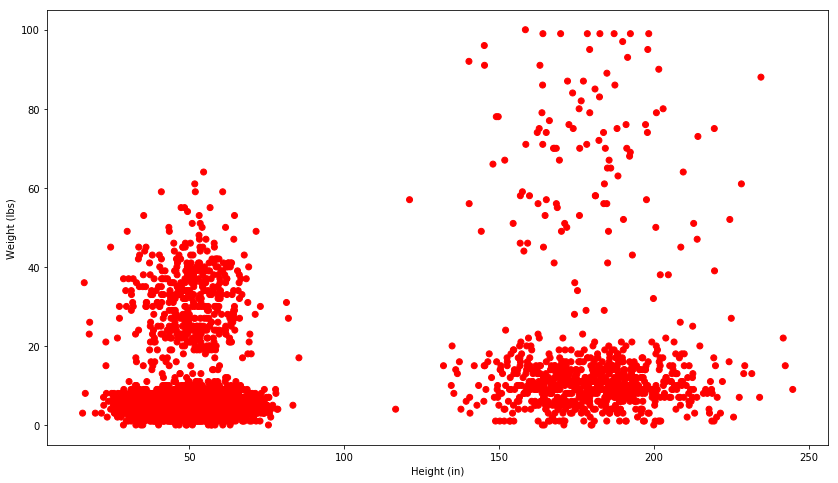

Delta: 8.74958324432373
Delta: 4.588191032409668
Delta: 0.632566511631012
Delta: 0.04175835847854614
Delta: 0.015913009643554688
Delta: 0.013514339923858643
Delta: 0.0
TF:


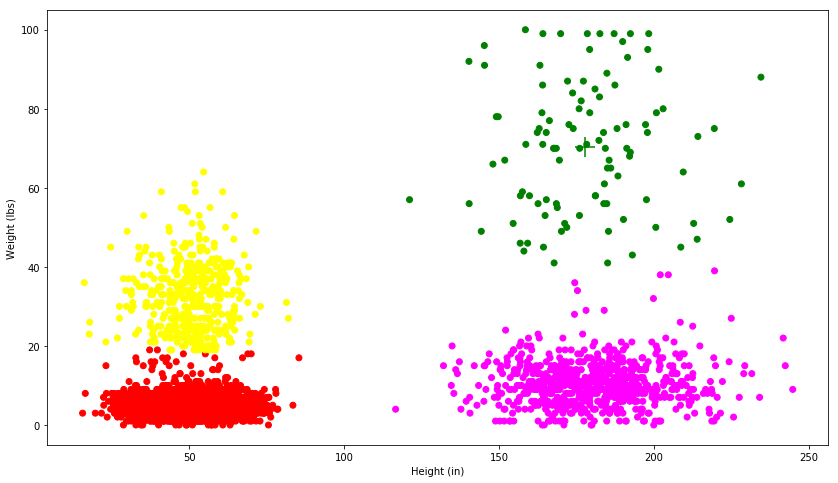

Loss:719601.538347454
sklearn:


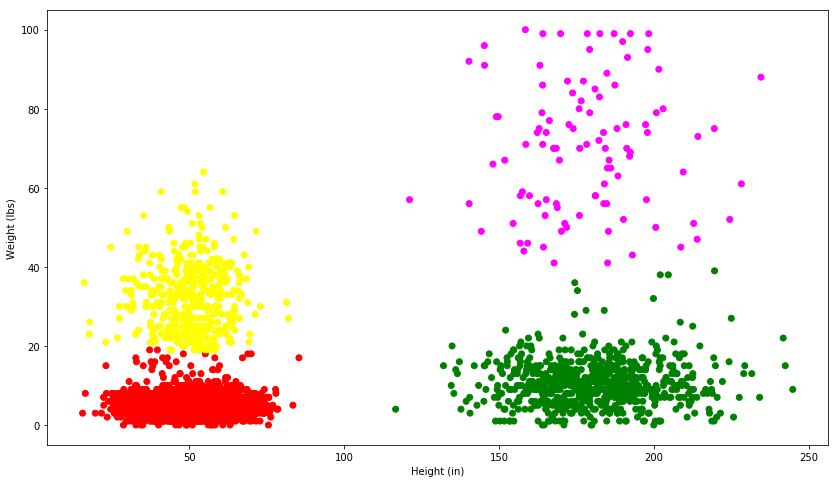

In [43]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# Pravi scatter plot podataka i klastera
def scatter_plot(X, Y, assignments=None, centers=None):
    
    # Ako nismo prosledili assignmente neka su svi dodeljeni klasteru 0
    if assignments is None:
        assignments = [0] * len(X)
    
    # Nzm sta ovo radi
    fig = plt.figure(figsize=(14,8))
     
    # Kolor mapa za klastere (do k=5)
    cmap = ListedColormap(['red', 'green', 'blue', 'magenta', 'yellow'])
    
    # Scatter plot
    plt.scatter(X, Y, c=assignments, cmap=cmap)
   
    # Nacrtati centre ako postoje
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c=range(len(centers)), 
                    marker='+', s=400, cmap=cmap)  
    
    # Oznake osa
    plt.xlabel('Height (in)')
    plt.ylabel('Weight (lbs)')
    plt.show()

# Ucitavanje podataka
#data = np.loadtxt('kmeans_data.csv', delimiter=',', usecols=(1, 2))
data = np.loadtxt('kmeans_data_drivers.csv', skiprows=1, delimiter='\t', usecols=(1, 2))
print(data[:4])
    
# Scater plot samo podataka
scatter_plot(data[:, 0], data[:, 1])

# K-means za k=3
# tf.contrib.factorization.KMeansClustering zahteva podatke kao input_fn
k = 4
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(data, dtype=tf.float32), num_epochs=1)
kmeans = tf.contrib.factorization.KMeansClustering(use_mini_batch=False, num_clusters=k)

# Radimo K-means iteracije dok azuriranje centroida nije premalo
previous_centers = None
delta = 100

while delta > 0.0001:
  kmeans.train(input_fn = input_fn)
  centers = kmeans.cluster_centers()
  if previous_centers is not None:
    delta = np.average(np.abs(centers - previous_centers))
    print('Delta: {}'.format(delta))
  previous_centers = centers

# Izvlacimo dodele i centre i plotujemo
assignments = list(kmeans.predict_cluster_index(input_fn))
print('TF:')
scatter_plot(data[:, 0], data[:, 1], assignments, centers)

# Racunamo funkciju troska
print("Loss:{}".format(np.sum(np.square(centers[assignments] - data))))

# sklearn implementacija, za poredjenje
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(data)
print('sklearn:')
scatter_plot(data[:, 0], data[:, 1], kmeans.labels_)

# TODO: implementirati u numpy i uporediti